In [1]:
using Pkg
pkg"activate .."

 Activating environment at `~/Research/SkewHierarchicalTest/Project.toml`


In [2]:
using Distributions
using LaTeXStrings
using ReverseDiff
using SkewHierarchicalTest
using StatsPlots
using Turing

┌ Info: Precompiling ReverseDiff [37e2e3b7-166d-5795-8a7a-e32c996b4267]
└ @ Base loading.jl:1278


[Turing](https://turing.ml/stable/) needs to be told to use a reverse-diff package (by default it uses [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl), which is often a lot more efficient, but suffers from $\mathcal{O}(N)$ cost for $\mathbb{R}^N \to \mathbb{R}$ posterior log-probability functions).  Here we use [ReverseDiff.jl](https://github.com/JuliaDiff/ReverseDiff.jl), which is a "tape based" reverse autodiff package; another reasonable choice would be [Zygote.jl](https://github.com/FluxML/Zygote.jl) which is a very elegant source-to-source package that exploits Julia's macro/metaprogramming capability to transform your code into reverse-mode autodiff code.  However, Zygote does not deal well with array broadcasting ("." syntax), so it considerably slower than `ReverseDiff` due to the line 
```julia
x = exp.(mu .+ sigma.*log_x_unit)
```

In [3]:
Turing.setadbackend(:reversediff)

:reversediff

Our model here is very simple; it is similar to the [Isi, Chatziioannou, & Farr (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123l1101I/abstract) model, but using log-normals (which have skew) rather than normals.  We assume that there is some true value $x_i$ that is log-normally distributed:
$$
\log x_i \sim N\left( \mu, \sigma \right)
$$
with parameters $\mu$ and $\sigma$.  We then measure each $x_i$ imperfectly, with 
$$
\log x_{i,\mathrm{obs}} \sim N\left( \log x_i, \sigma_i \right).
$$
The $\sigma_i$ are assumed known but can vary from measurement to measurement (i.e. the measurement model is heteroskedastic).

We stress the model by *actually* choosing each $x_i = X$, some constant.  Thus the "true" values of the parameters $\mu$ and $\sigma$ are 
$$
\mu = \log X \\
\sigma = 0.
$$

In [4]:
@model function lognormal_lognormal(x_obs, sigma_obs)
    N = length(x_obs)
    
    mu ~ Normal(0,1)
    sigma ~ truncated(Normal(0,1), 0, Inf)
    
    log_x_unit ~ filldist(Normal(0,1), N) # N(0,1) unit randoms to produce x.
    x = exp.(mu .+ sigma.*log_x_unit) # Note the "." syntax, which creates a single fused loop for the array arithmetic.
    
    x_obs ~ arraydist([LogNormal(log(x[i]), sigma_obs[i]) for i in 1:N])
    
    return (x = x,) # By returning a named tuple, we "generate" values of derived quantites that aren't automatically included in the chain
end

lognormal_lognormal (generic function with 1 method)

Generate some data (fixed seed):

In [5]:
N, x, sigma_obs, x_obs = with_seed(2758701911387860309) do 
    N = 100
    x = ones(N) # True value is fixed
    sigma_obs = 0.5 .+ rand(N)
    x_obs = exp.(log.(x) .+ sigma_obs.*randn(N))
    (N, x, sigma_obs, x_obs)
end;

Plot the likelihoods:

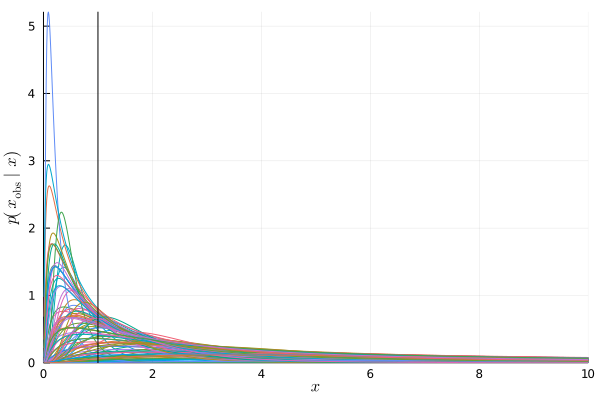

In [6]:
xs = 0.01:0.01:10.0
plot(xs, [pdf(LogNormal(log(xs[i]), sigma_obs[j]), x_obs[j]) for i in 1:length(xs), j in 1:N], legend=nothing,
     xlabel=L"x", ylabel=L"p\left( x_\mathrm{obs} \mid x \right)",
     xlims=(0,Inf), ylims=(0,Inf))
vline!([1.0], color=:black)

In [7]:
model = lognormal_lognormal(x_obs, sigma_obs)
trace = sample(model, NUTS(), 1000, progress=true)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/PyTy2/src/inference/hmc.jl:188
Sampling:   9%|███▉                                     |  ETA: 0:00:24┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/wfarr/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  16%|██████▋                                  |  ETA: 0:00:19┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/wfarr/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  30%|████████████▎                            |  ETA: 0:00:12┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/wfarr/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonia

Chains MCMC chain (1000×114×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = log_x_unit[1], log_x_unit[2], log_x_unit[3], log_x_unit[4], log_x_unit[5], log_x_unit[6], log_x_unit[7], log_x_unit[8], log_x_unit[9], log_x_unit[10], log_x_unit[11], log_x_unit[12], log_x_unit[13], log_x_unit[14], log_x_unit[15], log_x_unit[16], log_x_unit[17], log_x_unit[18], log_x_unit[19], log_x_unit[20], log_x_unit[21], log_x_unit[22], log_x_unit[23], log_x_unit[24], log_x_unit[25], log_x_unit[26], log_x_unit[27], log_x_unit[28], log_x_unit[29], log_x_unit[30], log_x_unit[31], log_x_unit[32], log_x_unit[33], log_x_unit[34], log_x_unit[35], log_x_unit[36], log_x_unit[37], log_x_unit[38], log_x_unit[39], log_x_unit[40], log_x_unit[41], log_x_unit[42], log_x_unit[43], log_x_unit[44], log_x_unit[45], log_x_unit[46], log_x_unit[47], log_x_unit[48], log_x_unit[49], log_x_unit[50], log_x_unit[51], log_x_unit[52], log_x_unit[

In [8]:
genq = generated_quantities(model, trace);

Let's look at the hyperparameter traces.  As we might expect, the uncertainty on $\mu$ (remember that all the $x_i$ have a common value) is about $10\%$ of the single-observation measurement uncertainty ($\sim 1$) because we have $N = 100$ events.  It looks like the true values of $\mu = 0$, $\sigma = 0$ are consistent with our measurement.

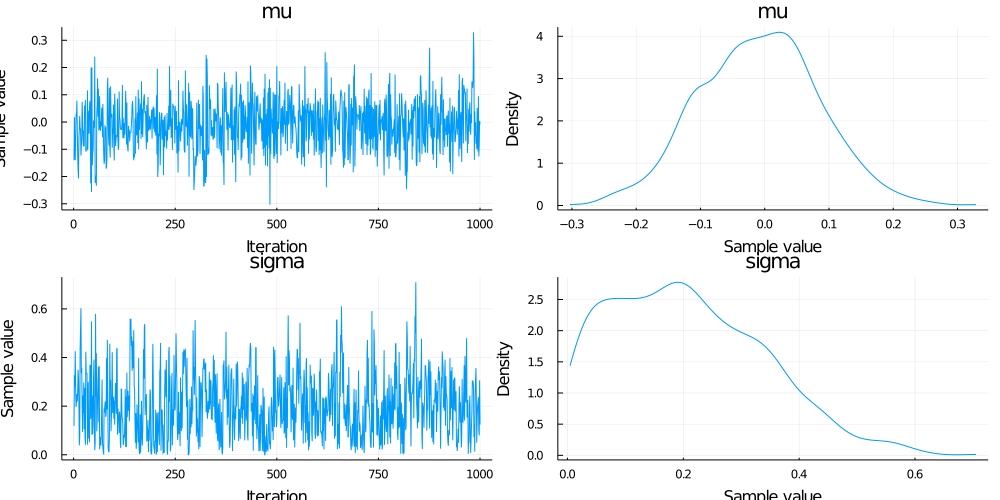

In [9]:
plot(trace, [:mu, :sigma])

2D density of hyperparameters:

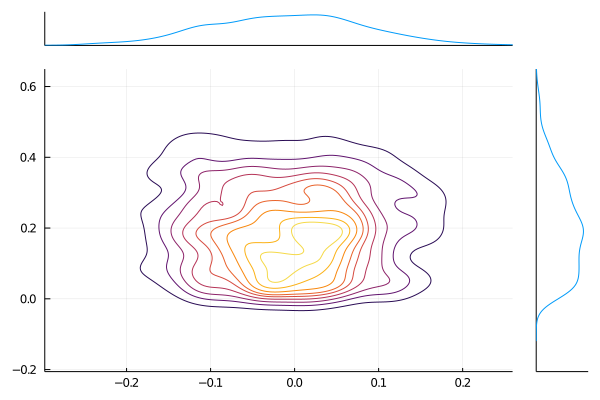

In [12]:
@df trace marginalkde(:mu, :sigma, labels=[L"\mu", L"\sigma"])

Here is the inferred population:

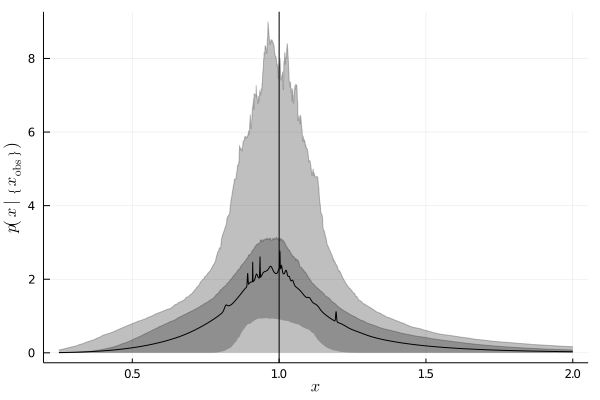

In [35]:
xs = 0.25:0.001:2.0
pdfs = map((m,s) -> pdf.(LogNormal(m, s), xs), trace[:mu], trace[:sigma])

m = [mean([p[i] for p in pdfs]) for i in eachindex(xs)]
l = [quantile(vec([p[i] for p in pdfs]), 0.16) for i in eachindex(xs)]
h = [quantile(vec([p[i] for p in pdfs]), 0.84) for i in eachindex(xs)]
ll = [quantile(vec([p[i] for p in pdfs]), 0.025) for i in eachindex(xs)]
hh = [quantile(vec([p[i] for p in pdfs]), 0.975) for i in eachindex(xs)]
plot(xs, m, color=:black, legend=nothing, xlabel=L"x", ylabel=L"p\left( x \mid \left\{ x_\mathrm{obs} \right\} \right)")
plot!(xs, h, fillrange=l, color=:black, alpha=0.25)
plot!(xs, hh, fillrange=ll, color=:black, alpha=0.25)
vline!([1.0], color=:black)

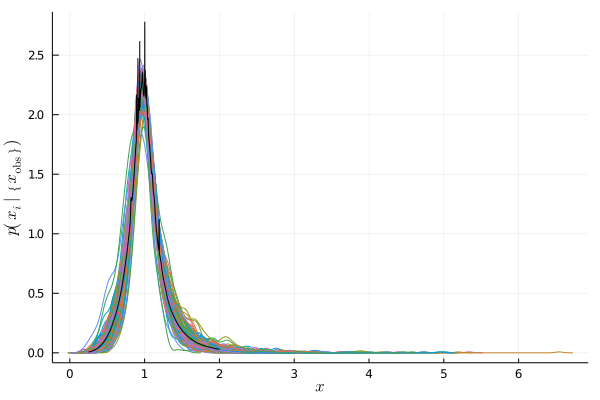

In [38]:
p = plot(xlabel=L"x", ylabel=L"p\left( x_i \mid \left\{ x_\mathrm{obs} \right\}\right)")
for i in 1:N
    p = density!([g.x[i] for g in genq])
end
plot!(xs, m, legend=nothing, color=:black)